## Dependencies
Due to a clash in the latest production version of curves and cmdty_storage package on PyPI, this workbook requires specific prerelease version of these installed. Run the following commands to install the required version, including the --upgrade flag if another version of either package is already installed:

`
pip install curves==1.0.1a1
pip install cmdty-storage=0.1.0a7
`


In [1]:
import pandas as pd
import numpy as np
from cmdty_storage import multi_factor as mf
from datetime import date

factors = [ # Tuples where 1st element is factor mean-reversion, 2nd element is factor vol curve
    (0.0, {date(2020, 8, 1): 0.35,
           '2021-01-15': 0.29,  # Can use string to specify forward delivery date
           date(2021, 7, 30): 0.32}),
    # factor vol can also be specified as a pandas Series
    (2.5, pd.Series(data=[0.15, 0.18, 0.21],
                    index=pd.PeriodIndex(data=['2020-08-01', '2021-01-15', '2021-07-30'], freq='D'))),
    (16.2, {date(2020, 8, 1): 0.95,
           '2021-01-15': 0.92,
           date(2021, 7, 30): 0.89}),
]

factor_corrs = np.array([
    [1.0, 0.6, 0.3],
    [0.6, 1.0, 0.4],
    [0.3, 0.4, 1.0]
])

# Like with factor vol, the fwd_curve can be a pandas Series object
fwd_curve = {
    '2020-08-01': 56.85,
    pd.Period('2021-01-15', freq='D'): 59.08,
    date(2021, 7, 30): 62.453
}
current_date = date(2020, 7, 27)
# Demonstrates different ways tp specify spot periods to simulate. Easier in practice to just use
# keys of fwd_curve
spot_periods_to_sim = [pd.Period('2020-08-01'), '2021-01-15', date(2021, 7, 30)]

random_seed = 12
spot_simulator = mf.MultiFactorSpotSim('D', factors, factor_corrs, current_date, fwd_curve,
                                       spot_periods_to_sim, random_seed)
num_sims = 10
sim_spot_prices = spot_simulator.simulate(num_sims)
sim_spot_prices


,0,1,2,3,4,5,6,7,8,9
2020-08-01,52.599764,46.120645,58.158386,65.500442,54.757762,41.735160,57.339342,65.826519,51.985379,66.955435
2021-01-15,57.559632,72.038109,82.496072,42.812677,67.569646,108.521932,54.340192,63.570074,56.546447,101.403544
2021-07-30,89.405270,85.188698,138.685873,76.586791,89.084392,59.093985,44.651675,46.479830,42.948411,96.374054


In [2]:
from curves import max_smooth_interp

def create_3_factor_params(freq, spot_vol, spot_mean_reversion, long_term_vol, seasonal_vol, seasonal_vol_shape,
                          curve_start, curve_end):
    factor_corrs = np.eye(3) # Factors are uncorrelated
    vol_date_indices = pd.period_range(start=curve_start, end=curve_end, freq=freq)
    num_curve_points = len(vol_date_indices)
    
    long_term_vol_curve = pd.Series(data = [long_term_vol] * num_curve_points, index = vol_date_indices)
    long_term_factor = (0.0, long_term_vol_curve) # Zero mean reversion of long term factor
    
    spot_vol_curve = pd.Series(data = [spot_vol] * num_curve_points, index = vol_date_indices)
    spot_factor = (spot_mean_reversion, spot_vol_curve)
    
    months = vol_date_indices.asfreq('M').drop_duplicates()
    monthly_seasonal_vol = pd.Series(data = [1.0] * len(months), index = months)
    for month in months:
        monthly_seasonal_vol[month] = seasonal_vol_shape[month.month] * seasonal_vol
        
    daily_seasonal_vol = max_smooth_interp(monthly_seasonal_vol, freq='D')
    
    seasonal_factor = (0.0, daily_seasonal_vol)
    
    return [spot_factor, long_term_factor, seasonal_factor], factor_corrs

Text(0.5, 1.0, 'Foward Volatility')

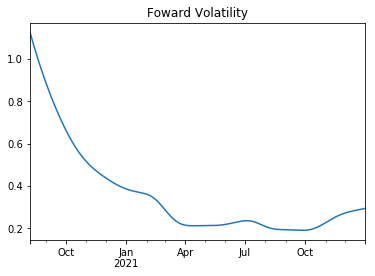

In [3]:
# Completely made up parameters
spot_vol = 1.1
spot_mean_reversion = 3.7
long_term_vol = 0.19
seasonal_vol = 0.34
seasonal_vol_shape = {1: 0.7,  # key = month of the year
                      2: 0.65, 
                      3: 0.25, 
                      4: -0.1, 
                      5: -0.22,
                      6: -0.34,
                      7: -0.35,
                      8: -0.14,
                      9: -0.05,
                      10: 0.19,
                      11: 0.48,
                      12: 0.62}
curve_start = '2020-08-07'
curve_end = '2023-12-31'

factors, factor_corrs = create_3_factor_params('D', spot_vol, spot_mean_reversion, long_term_vol, 
                                   seasonal_vol, seasonal_vol_shape, curve_start, curve_end)

three_f_model = mf.MultiFactorModel('D', factors, factor_corrs)

days = pd.period_range(start=curve_start, end='2021-12-31', freq='D')
fwd_vols = [three_f_model.integrated_vol(val_date=curve_start, expiry='2020-08-08', fwd_contract=day) for day in days]

fwd_vols_series = pd.Series(data = fwd_vols, index = days)
%matplotlib inline
ax1 = fwd_vols_series.plot()
ax1.set_title('Foward Volatility')

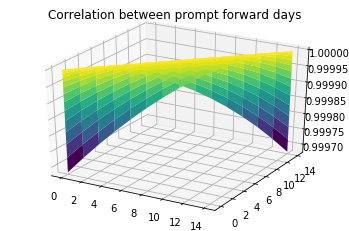

In [4]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
ax = plt.axes(projection='3d')

prompt_days = days[0:15]

num_prompt_days = len(prompt_days)
corrs = np.zeros((num_prompt_days, num_prompt_days))

for i, dt1 in enumerate(prompt_days):
    for j, dt2 in enumerate(prompt_days):
        if i >= j:
            corrs[i, j] = three_f_model.integrated_corr(curve_start, '2020-08-08', dt1, dt2)
            if i != j:
                corrs[j, i] =corrs[i, j] # Make use of symmetry

x = range(num_prompt_days)
y = x
ax.plot_surface(x, y, corrs, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Correlation between prompt forward days');
